In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
import re
import nltk
nltk.download('stopwords');
import time
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import collections
from numpy import linalg as la
import string
import pickle
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xoelr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data

In [2]:

index = pickle.load( open( "index.p", "rb" ) )
tf = pickle.load( open( "tf.p", "rb" ) )
idf = pickle.load(open( "idf.p", "rb" ) )
df =pickle.load( open( "df.p", "rb" ) )

In [3]:
df_tweets = pd.read_csv('tweets_cleaned.csv')
df_tweets = df_tweets.drop(columns = 'Unnamed: 0')
df_tweets.head()

,created_at,id,text,user,quote_count,reply_count,retweet_count,favorite_count,URL
0,Mon Nov 30 17:54:03 +0000 2020,1333469355435290624,@OfficialPLT https://t.co/3QeXmMdYeQ\nPlease c...,L🦄 PLT notice me,0,0,0,0,https://t.co/2fVluwbnIA
1,Mon Nov 30 17:54:03 +0000 2020,1333469355967995910,"N.J. reports 3,199 new COVID-19 cases, 15 more...",Maria Bonanno,0,0,0,0,https://t.co/1gNzZbl627
2,Mon Nov 30 17:54:03 +0000 2020,1333469356232159233,👏👏👏 good start to recognise all the work done ...,Christina Owen,0,0,0,0,https://t.co/u4sMu4fsIY
3,Mon Nov 30 17:54:03 +0000 2020,1333469356647444483,@FLOTUS @WhiteHouse Are those Red Covid crowns...,Pasodoble,0,0,0,0,NaN
4,Mon Nov 30 17:54:03 +0000 2020,1333469356647473162,@ScottBaio @LAPDHQ @LADAOffice 🇺🇳United Nation...,PATRIOTS 🆚 Globalists,0,0,0,0,https://t.co/tYCmnuwnSi


In [4]:
def getTerms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
        
    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))
    ## START CODE
    line=  line.lower() ## Transform in lowercase
    line=  line.split() ## Tokenize the text to get a list of terms
    line=[word for word in line if not word in stops]  ##eliminate the stopwords (HINT: use List Comprehension)
    line=[stemming.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    ## END CODE
    return line

### TF-IDF + cosine similarity

In [5]:
def rankDocuments(terms, docs, index, idf, tf,tweets):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """
        
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(terms)    
    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for queryVector
    query_norm = la.norm(list(query_terms_count.values()))
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term]
        
        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]  # TODO: check if multiply for idf

    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine siilarity
    # see np.dot
    
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    #print document titles instead if document id's
    #resultDocs=[ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again") 
    #print ('\n'.join(resultDocs), '\n')
    return resultDocs

In [6]:
def search_tf_idf(query, index, tweets):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=getTerms(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            # docs = docs Union termDocs
            docs = docs.union(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf, tweets)
    return ranked_docs

# Selection of queries

In [7]:
dict(sorted(df.items(), key=lambda item: item[1], reverse = True))

{'rt': 54627,
 'covid': 31241,
 'covid19': 22632,
 'pandem': 17190,
 'test': 11850,
 'coronaviru': 10700,
 'peopl': 9107,
 'get': 6076,
 'year': 5833,
 'posit': 5704,
 'work': 5510,
 'case': 5386,
 'amp': 5039,
 'new': 5013,
 'vaccin': 4978,
 'us': 4757,
 'like': 4531,
 'want': 4505,
 'know': 4466,
 'one': 4453,
 'world': 4417,
 'say': 4135,
 'go': 4118,
 'death': 4090,
 'would': 4084,
 'lewi': 4074,
 'need': 3970,
 'hamilton': 3938,
 'neg': 3916,
 'time': 3769,
 'china': 3654,
 'day': 3643,
 'break': 3624,
 'make': 3584,
 'miss': 3499,
 'due': 3456,
 'even': 3306,
 'pleas': 3060,
 'today': 3046,
 'pltpinkmonday': 3006,
 'trump': 2992,
 'help': 2984,
 'govern': 2913,
 'officialplt': 2846,
 'sakhir': 2838,
 'week': 2829,
 'it’': 2749,
 'grand': 2714,
 'die': 2679,
 'weekend': 2665,
 'health': 2654,
 'prix': 2652,
 'still': 2599,
 'month': 2580,
 'nct': 2577,
 'think': 2555,
 'take': 2529,
 'f1': 2507,
 'cnn': 2407,
 'see': 2399,
 'around': 2389,
 'busi': 2366,
 'got': 2343,
 'show': 233

In [8]:
queries = ['coronavirus test positive','covid19 pandemic','covid vaccine','people want vaccine','new vaccine coronavirus',
          'new cases coronavirus', 'covid death', 'covid china cases', 'coronavirus day cases','coronavirus hamilton']

In [9]:

   
top = 20
for query in queries:
    ranked_docs = search_tf_idf(query, index,df_tweets) 
    print("\n======================\nTop {} results out of {} for ({}):\n".format(top, len(ranked_docs),query))
    for d_id in ranked_docs[:top] :
        print('-------------------------------------')
        print('Tweet: ' + df_tweets.loc[d_id,'text'])
        print('User: ' + df_tweets.loc[d_id,'user'])
        print('Date: ' +  df_tweets.loc[d_id,'created_at'])
        print('Likes: ' + str(df_tweets.loc[d_id,'favorite_count']))
        print('Retweets: ' + str(df_tweets.loc[d_id,'retweet_count']))
        if type(df_tweets.loc[d_id,'URL']) != str:
            print('No URL available')
        else:
            print('URL: ' + str(df_tweets.loc[d_id,'URL']))


Top 20 results out of 20443 for (coronavirus test positive):

-------------------------------------
Tweet: Hamilton tests positive for coronavirus
https://t.co/1gBvI7Fz03
User: Gareth Herincx
Date: Tue Dec 01 08:47:20 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/1gBvI7Fz03
-------------------------------------
Tweet: Lewis Hamilton tests positive for coronavirus
User: Mazi Urch_mann
Date: Tue Dec 01 08:41:35 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Lewis Hamilton tests positive for coronavirus.
User: Vishal 🕉
Date: Tue Dec 01 08:38:17 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Lewis Hamilton Tests positive for coronavirus
User: BRAVIN YURI
Date: Tue Dec 01 08:20:19 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: @spectatorindex JUST IN: Anybody tests positive for coronavirus
User: Exotic Scouse ❁
Date: Tue Dec 01 08:08:18 +0000 2020


Top 20 results out of 16126 for (people want vaccine):

-------------------------------------
Tweet: No Vaccines there then?????
User: FreeSpirit
Date: Tue Dec 01 09:19:25 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Who is the maker of this covid vaccine? Want to look it up
User: Sorchamac
Date: Tue Dec 01 08:44:21 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: No more flying for me if this happens. I never want this vaccine.
User: Tml
Date: Mon Nov 30 18:10:10 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: NHS Wants ‘Sensible Celebrities’ To Persuade People To Take Coronavirus Vaccine

https://t.co/VmITUJcPSI
User: wellness-club@hotmai
Date: Mon Nov 30 18:17:22 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/VmITUJcPSI
-------------------------------------
Tweet: More vaccine for the sane people. https://t.co/eu9XLx69Z0
User: CountryOverPar


Top 20 results out of 18623 for (new cases coronavirus):

-------------------------------------
Tweet: RT @MattMurph24: 161,568 new Coronavirus cases
User: Jeff Haner
Date: Tue Dec 01 08:16:21 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: 10 New Cases Of Coronavirus In The Premier League https://t.co/CutE3ZB40w
User: Upcomingrapper
Date: Tue Dec 01 08:18:17 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/CutE3ZB40w
-------------------------------------
Tweet: 121 new coronavirus cases, 108 recoveries https://t.co/JDv1zMqQ7y
User: Daniel Zion Essien
Date: Mon Nov 30 18:13:45 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/JDv1zMqQ7y
-------------------------------------
Tweet: #Italy records 16,377 new #coronavirus cases https://t.co/Mgp3KBWc62
User: British Herald
Date: Mon Nov 30 18:10:02 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/Mgp3KBWc62
-------------------------------------
Tweet: Coronavirus: One death, 182 new cases ht


Top 20 results out of 36412 for (covid china cases):

-------------------------------------
Tweet: CHINA IS SO INNOCENT
User: President Elect Agnes Norman
Date: Tue Dec 01 09:13:56 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: FUCK CHINA
User: Eiman
Date: Tue Dec 01 08:44:29 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Fuk China
User: baz macca
Date: Tue Dec 01 08:14:51 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Cheater China
User: Umesh Kashyap
Date: Tue Dec 01 08:00:42 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: CHINA... Lie.... No!
User: CooperUSA
Date: Tue Dec 01 07:56:56 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: WHO/UN continuing to plead China's case over the coronavirus https://t.co/0IynL0Xj5U
User: Kyle Orton
Date: Tue Dec 01 08:48


Top 20 results out of 13751 for (coronavirus hamilton):

-------------------------------------
Tweet: Hamilton has Covid????
User: M@rtìñ Ød̪égåård̪SZN🇳🇴 (:
Date: Tue Dec 01 08:17:24 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Poor Hamilton
User: Aref Naser🇲🇾🇲🇾🇲🇾
Date: Tue Dec 01 08:06:34 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Hamilton tests positive for coronavirus
https://t.co/1gBvI7Fz03
User: Gareth Herincx
Date: Tue Dec 01 08:47:20 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/1gBvI7Fz03
-------------------------------------
Tweet: Lewis Hamilton tests positive for coronavirus
User: Mazi Urch_mann
Date: Tue Dec 01 08:41:35 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Lewis Hamilton tests positive for coronavirus.
User: Vishal 🕉
Date: Tue Dec 01 08:38:17 +0000 2020
Likes: 0
Retweets: 0
No URL available
------------------------

### Word2Vec + cosine similarity

In [10]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, WordEmbeddingSimilarityIndex
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix

In [11]:
%%time
stemming = PorterStemmer()
stops = set(stopwords.words("english"))
df_tweets['processed_text'] = pd.Series(dtype='object')
for index, row in df_tweets.iterrows():
    line = row['text']
    line=  line.lower()
    line = line.translate(str.maketrans('', '', string.punctuation))
    line=  line.split()
    line=[word for word in line if not word in stops]  
    line=[stemming.stem(word) for word in line] 
    df_tweets.at[index,'processed_text'] = line
df_tweets.head()

Wall time: 37.1 s


,created_at,id,text,user,quote_count,reply_count,retweet_count,favorite_count,URL,processed_text
0,Mon Nov 30 17:54:03 +0000 2020,1333469355435290624,@OfficialPLT https://t.co/3QeXmMdYeQ\nPlease c...,L🦄 PLT notice me,0,0,0,0,https://t.co/2fVluwbnIA,"[officialplt, httpstco3qexmmdyeq, pleas, choos..."
1,Mon Nov 30 17:54:03 +0000 2020,1333469355967995910,"N.J. reports 3,199 new COVID-19 cases, 15 more...",Maria Bonanno,0,0,0,0,https://t.co/1gNzZbl627,"[nj, report, 3199, new, covid19, case, 15, dea..."
2,Mon Nov 30 17:54:03 +0000 2020,1333469356232159233,👏👏👏 good start to recognise all the work done ...,Christina Owen,0,0,0,0,https://t.co/u4sMu4fsIY,"[👏👏👏, good, start, recognis, work, done, throu..."
3,Mon Nov 30 17:54:03 +0000 2020,1333469356647444483,@FLOTUS @WhiteHouse Are those Red Covid crowns...,Pasodoble,0,0,0,0,NaN,"[flotu, whitehous, red, covid, crown, see, dec..."
4,Mon Nov 30 17:54:03 +0000 2020,1333469356647473162,@ScottBaio @LAPDHQ @LADAOffice 🇺🇳United Nation...,PATRIOTS 🆚 Globalists,0,0,0,0,https://t.co/tYCmnuwnSi,"[scottbaio, lapdhq, ladaoffic, 🇺🇳unit, nation,..."


In [12]:
# Build word2vec model
model = Word2Vec(df_tweets['processed_text'],size = 200, window = 5, min_count = 5,workers = multiprocessing.cpu_count())

In [14]:
termsim_index = WordEmbeddingSimilarityIndex(model.wv)
corpus_list_token = df_tweets['processed_text']
dictionary = Dictionary(corpus_list_token)
bow_corpus = [dictionary.doc2bow(document) for document in corpus_list_token]
similarity_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary)

In [15]:
docsim_index = SoftCosineSimilarity(bow_corpus, similarity_matrix, num_best=20)


In [16]:
for query in queries:
    query1 = getTerms(query)
    sims = docsim_index[dictionary.doc2bow(query1)]
    result_list = [i for i in [a[0] for a in sims]]
    score_list = [a[1] for a in sims]
    print("\n======================\nTop {} results for ({}):\n".format(top,query))
    for d_id in result_list:
        print('-------------------------------------')
        print('Tweet: ' + df_tweets.loc[d_id,'text'])
        print('User: ' + df_tweets.loc[d_id,'user'])
        print('Date: ' +  df_tweets.loc[d_id,'created_at'])
        print('Likes: ' + str(df_tweets.loc[d_id,'favorite_count']))
        print('Retweets: ' + str(df_tweets.loc[d_id,'retweet_count']))
        if type(df_tweets.loc[d_id,'URL']) != str:
            print('No URL available')
        else:
            print('URL: ' + str(df_tweets.loc[d_id,'URL']))


C:\Users\xoelr\anaconda3\envs\mining\lib\site-packages\gensim\similarities\termsim.py:358: RuntimeWarning: divide by zero encountered in true_divide
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
C:\Users\xoelr\anaconda3\envs\mining\lib\site-packages\gensim\similarities\termsim.py:358: RuntimeWarning: invalid value encountered in multiply
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))



Top 20 results for (coronavirus test positive):

-------------------------------------
Tweet: Chuck Grassley returns to Congress after positive coronavirus test https://t.co/caCHh5bLqz
User: Searching for a Better World
Date: Tue Dec 01 08:11:41 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/caCHh5bLqz
-------------------------------------
Tweet: Sweden’s Prince Carl Philip And Wife Test Positive For Coronavirus https://t.co/NlWeliz637
User: Charles Myrick -CEO
Date: Tue Dec 01 09:19:15 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/NlWeliz637
-------------------------------------
Tweet: Chuck Grassley returns to Congress after positive coronavirus test https://t.co/wDvT0619kH
User: Daily Update Talk
Date: Tue Dec 01 09:19:15 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/wDvT0619kH
-------------------------------------
Tweet: NEWS: An #Ashford @McDonalds's worker has tested positive for #coronavirus #kmfmnews https://t.co/wQNVt1jjsZ https://t.co/GStaT5DSod
User: kmfm News
Da


Top 20 results for (covid vaccine):

-------------------------------------
Tweet: i will snort the fattest line of covid vaccine the second it’s available to me
User: abdul 🤠🏴
Date: Mon Nov 30 18:15:37 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Politicians in Maha and some top IPS officers want to cut in to the line and get the covid vaccine before everyone else gets it- My story
https://t.co/wEicuF6awl
User: Krishnakumar
Date: Tue Dec 01 08:57:03 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/lULqUFdBs4
-------------------------------------
Tweet: RT @KellzBellzzah: 5 million have tested positive for COVID in AMERICA and 244,345 died.  Umm why do we need a vaccine?  5,000,000  SURVIVE…
User: TLG
Date: Tue Dec 01 08:15:22 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: A miracle on Covid relief, vaccination, economic recovery, world peace, environmental protection, health care package, 


Top 20 results for (new vaccine coronavirus):

-------------------------------------
Tweet: Incredible new drug might work even better than a coronavirus vaccine #SmartNews  https://t.co/azR7uBIoLW
User: Nick Holden
Date: Tue Dec 01 08:00:49 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/azR7uBIoLW
-------------------------------------
Tweet: AlL I wAnT 🎵 fOr ChRiStMas 🎵 is 🎵 ...a coronavirus vaccine and the green new deal.
User: Gabriela
Date: Mon Nov 30 17:57:18 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: NEW: Around 70 percent of #SaudiArabia’s population will receive a #Covid19 #vaccine free-of-charge it has been revealed #HealthNews #Coronavirus #KSA

https://t.co/ppLePMGSCh https://t.co/zKSc7KafuP
User: Odyssey Recruitment
Date: Tue Dec 01 08:12:03 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/SwZkF8Kmy4
-------------------------------------
Tweet: Prince Charles could REFUSE to take new coronavirus vaccine after previous 


Top 20 results for (covid death):

-------------------------------------
Tweet: Thread for those who thinking only death is the issue as it relates to COVID...

But somebody is gonna say oh the doctors are just saying that
User: leagueofextraordinary
Date: Mon Nov 30 18:06:30 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/9bvoRVCSCh
-------------------------------------
Tweet: RT @garygilligan: Great sensitivity from the Torygraph.

"Government saves £600m on state pension payments as Covid deaths surge"...
User: Bonnie Smith Dermody the real me
Date: Tue Dec 01 09:24:42 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: Funny how we never hear about the recovery from covid just deaths this puts it more into perspective
User: my mind is my own
Date: Tue Dec 01 08:09:36 +0000 2020
Likes: 0
Retweets: 0
No URL available
-------------------------------------
Tweet: @judynor00320887 @mrdavidduran @ossoff Oh god, his laughter during the debate w


Top 20 results for (coronavirus day cases):

-------------------------------------
Tweet: Iowa sees more than 2,000 new coronavirus cases in 1 day https://t.co/fyUQYYoDfI
User: Pehal News
Date: Mon Nov 30 18:20:12 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/fyUQYYoDfI
-------------------------------------
Tweet: Turkey has announced new coronavirus measures after reported new cases reached 30,000 a day. People will be banned from going out after 9pm on weekdays -- and forced to stay at home throughout the day on weekends. More on the @FT coronavirus live blog: https://t.co/8UA0pOArg5
User: Laura Pitel
Date: Mon Nov 30 17:59:15 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/17Q5Sp0tft
-------------------------------------
Tweet: Hi Latest Coronavirus news... Michigan confirms another 10400 coronavirus cases over 2 days https://t.co/mgqDvssZKH
User: Goodness Universe
Date: Tue Dec 01 08:23:08 +0000 2020
Likes: 0
Retweets: 0
URL: https://t.co/mgqDvssZKH
-------------------------

### TSNE

In [26]:
tweet_vectors = []
# For every tweet we compute the average of the vectors of its words
for text in df_tweets['processed_text']:
    word_vector = np.zeros(200)
    words_not_vocab = 0
    for token in text:
        try:
            word_vector+= model[token]
        except:
            words_not_vocab += 1
    word_vector = word_vector/(len(text)-words_not_vocab)
    tweet_vectors.append(np.nan_to_num(word_vector))

C:\Users\xoelr\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\xoelr\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [27]:
X = tweet_vectors

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


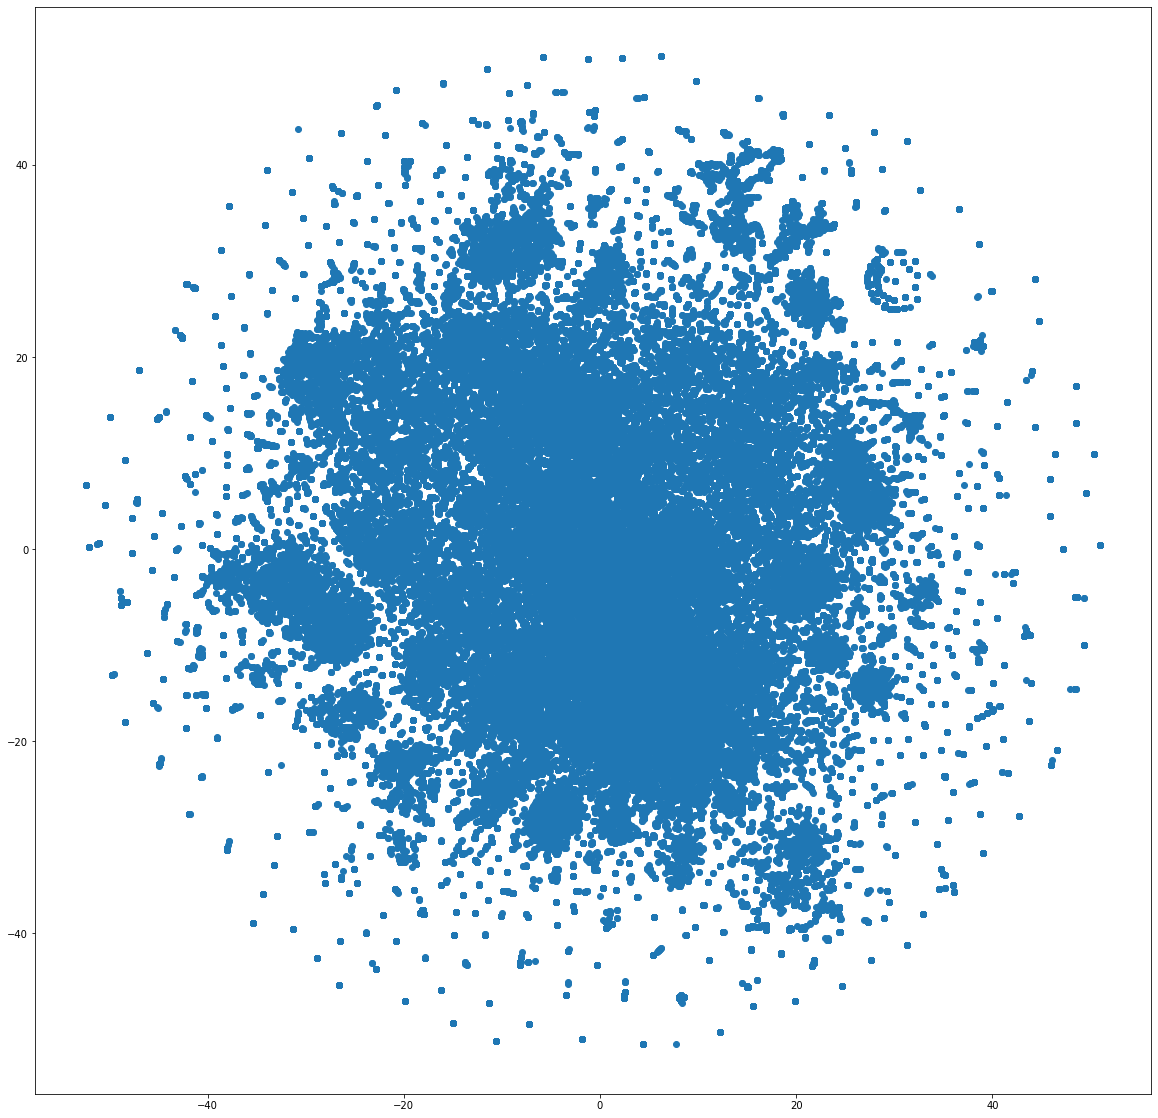

In [28]:
plt.figure(figsize=(20,20))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [29]:
#We save X_tsne to generate clusters later
pickle.dump(X_tsne ,open( "X_tsne.p", "wb" ) )